# Assignment 4 - Markov Decision Processes

In [128]:
import gym
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from collections import defaultdict
import itertools 
import random

## Frozen lake problem

In [129]:
# testing
env = gym.make('FrozenLake8x8-v0', is_slippery=True)
observation = env.reset()
env.env.s = 62 # go to state s
s_next, r, done, info = env.step(3)
env.render()
env.close()
print("Next state: {} Reward: {} Done: {} Info: {}".format(s_next, r, done, info))

(Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Next state: 63 Reward: 1.0 Done: True Info: {'prob': 0.3333333333333333}


### Value Iteration

In [496]:
# the following function was inspired by and adapted from: https://github.com/realdiganta/solving_openai/blob/master/FrozenLake8x8/frozenLake8x8.py
def value_iteration(env, max_iterations=100000, lmbda=0.9, verbose=1):
    stateValue = [0 for i in range(env.nS)]
    newStateValue = stateValue.copy()
    for i in range(max_iterations):
        
        if verbose>0: print("Iteration: {}".format(i))
        
        for state in range(env.nS):
            action_values = []      
            
            for action in range(env.nA):
                state_value = 0
                
                for s in range(len(env.P[state][action])):
                    prob, next_state, reward, done = env.P[state][action][s]
                    
                    if verbose>1: 
                        print("Iteration: {} State: {} Action: {} Prob: {} Next State: {} Reward: {}".format(i, state, action, prob, next_state, reward))
                    state_action_value = prob * (reward + lmbda*stateValue[next_state])
                    state_value += state_action_value
                
                action_values.append(state_value)
                best_action = np.argmax(np.asarray(action_values))
                newStateValue[state] = action_values[best_action]
        
        # if i > 1000: 
        if verbose>0: print("Delta V: {}".format(np.max(np.abs(np.array(stateValue) - np.array(newStateValue)))))
        if np.max(np.abs(np.array(stateValue) - np.array(newStateValue))) < 0.0001:
            break
            
        stateValue = newStateValue.copy()
    return stateValue 

In [497]:
# the following function was inspired by and adapted from: https://github.com/realdiganta/solving_openai/blob/master/FrozenLake8x8/frozenLake8x8.py
def get_policy(env,stateValue, lmbda=0.9):
    policy = [0 for i in range(env.nS)]
    for state in range(env.nS):
        action_values = []
        for action in range(env.nA):
            action_value = 0
            # print(env.P[state][action])
            for i in range(len(env.P[state][action])):
                prob, next_state, r, _ = env.P[state][action][i]
                # print("I: {} R: {}".format(i, r))
                action_value += prob * (r + lmbda * stateValue[next_state])
            action_values.append(action_value)
        best_action = np.argmax(np.asarray(action_values))
        policy[state] = best_action
        # print("State: {} Action Values: {} Best Action: {}".format(state, action_values, best_action))
    return policy 

In [498]:
# the following function was inspired by and adapted from: https://github.com/realdiganta/solving_openai/blob/master/FrozenLake8x8/frozenLake8x8.py
def get_score(env, policy, episodes=1000):
  misses = 0
  steps_list = []
  for episode in range(episodes):
    observation = env.reset()
    steps=0
    while True:
      
      action = policy[observation]
      observation, reward, done, _ = env.step(action)
      steps+=1
      if done and reward == 1:
        # print('You have got the Frisbee after {} steps'.format(steps))
        steps_list.append(steps)
        break
      elif done and reward == 0:
        # print("You fell in a hole!")
        misses += 1
        break
  print('----------------------------------------------')
  print('You took an average of {:.0f} steps to get the frisbee'.format(np.mean(steps_list)))
  print('And you fell in the hole {:.2f} % of the times'.format((misses/episodes) * 100))
  print('----------------------------------------------')


In [503]:
stateValues = value_iteration(env, max_iterations=100000, verbose=0)
policy_value_iteration = get_policy(env, stateValues)
get_score(env, policy_value_iteration,episodes=1000)

----------------------------------------------
You took an average of 73 steps to get the frisbee
And you fell in the hole 24.00 % of the times
----------------------------------------------


In [500]:
def display_state_values(V, env):
    nb_states = env.observation_space.n
    V = np.round(V, decimals=4)
    ax = sns.heatmap(V.reshape(int(np.sqrt(nb_states)),int(np.sqrt(nb_states))), 
                 linewidth=0.5,
                 annot=V.reshape(int(np.sqrt(nb_states)),int(np.sqrt(nb_states))), 
                 fmt = '',
                 cbar=False)
    plt.show()

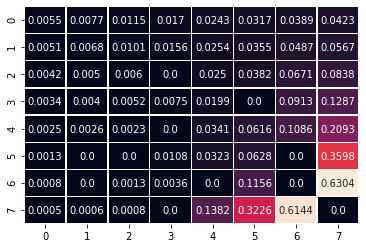

In [501]:
display_state_values(stateValues, env)
# LEFT = 0
# DOWN = 1
# RIGHT = 2
# UP = 3

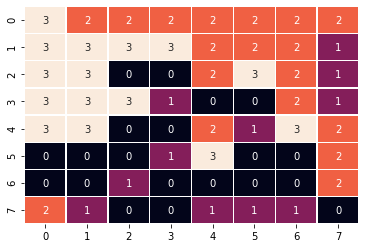

In [504]:
display_state_values(policy_value_iteration, env)
# LEFT = 0
# DOWN = 1
# RIGHT = 2
# UP = 3

### Policy Iteration

In [132]:
# the following function was inspired by and adapted from: https://github.com/hollygrimm/markov-decision-processes/blob/master/lab1/Lab%201%20-%20Problem%202.ipynb
def compute_vpi(pi, env, gamma):
    # use pi[state] to access the action that's prescribed by this policy
    
    a = np.identity(env.nS) 
    b = np.zeros(env.nS) 
    
    # print(a)
    # print(b)

    for state in range(env.nS):
        for probability, nextstate, reward, done in env.P[state][pi[state]]:
            a[state][nextstate] = a[state][nextstate] - gamma * probability
            b[state] += probability * reward

    # print(a)
    # print(b)
    
    V = np.linalg.solve(a, b)
    return V

In [133]:
pi = np.arange(64) % env.nA
Vpi = compute_vpi(pi, env, 0.9)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[ 0.4  0.   0.  ...  0.   0.   0. ]
 [-0.3  1.  -0.3 ...  0.   0.   0. ]
 [ 0.   0.   0.7 ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ...  0.7 -0.3  0. ]
 [ 0.   0.   0.  ...  0.   0.7 -0.3]
 [ 0.   0.   0.  ...  0.   0.   0.1]]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.    

In [485]:
# the following function was inspired by and adapted from: https://github.com/hollygrimm/markov-decision-processes/blob/master/lab1/Lab%201%20-%20Problem%202.ipynb
def compute_qpi(vpi, env, gamma):
    Qpi = np.zeros([env.nS, env.nA])
    for state in range(env.nS):
        for action in range(env.nA):
            for probability, nextstate, reward, done in env.P[state][action]:
                Qpi[state][action] += probability * (reward + gamma * vpi[nextstate]) 
    return Qpi

In [486]:
Qpi = compute_qpi(Vpi, env, 0.9)

In [489]:
# the following function was inspired by and adapted from: https://github.com/hollygrimm/markov-decision-processes/blob/master/lab1/Lab%201%20-%20Problem%202.ipynb
def policy_iteration(env, gamma, nIt):
    Vs = []
    pis = []
    pi_prev = np.zeros(env.nS, dtype='int')
    pis.append(pi_prev)
    print("Iteration | # chg actions | V[0]")
    print("----------+---------------+---------")
    for it in range(nIt):        
        
        # you need to compute qpi which is the state-action values for current pi
        vpi = compute_vpi(pis[-1], env, gamma=gamma)
        qpi = compute_qpi(vpi, env, gamma=gamma)
        pi = qpi.argmax(axis=1)
        print("%4i      | %6i        | %6.5f"%(it, (pi != pi_prev).sum(), vpi[0]))
        Vs.append(vpi)
        pis.append(pi)
        pi_prev = pi
    return Vs, pis

In [490]:
Vs_PI, pis_PI = policy_iteration(env, gamma=0.9, nIt=20)

Iteration | # chg actions | V[0]
----------+---------------+---------
   0      |     29        | 0.00000
   1      |     30        | 0.00000
   2      |     18        | 0.00001
   3      |      8        | 0.00539
   4      |      8        | 0.00631
   5      |      1        | 0.00641
   6      |      0        | 0.00641
   7      |      0        | 0.00641
   8      |      0        | 0.00641
   9      |      0        | 0.00641
  10      |      0        | 0.00641
  11      |      0        | 0.00641
  12      |      0        | 0.00641
  13      |      0        | 0.00641
  14      |      0        | 0.00641
  15      |      0        | 0.00641
  16      |      0        | 0.00641
  17      |      0        | 0.00641
  18      |      0        | 0.00641
  19      |      0        | 0.00641


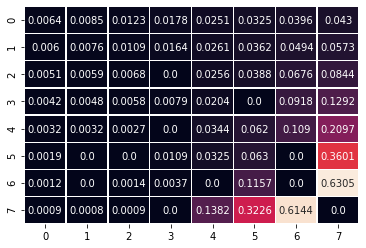

In [491]:
display_state_values(Vs_PI[-1], env)
# LEFT = 0
# DOWN = 1
# RIGHT = 2
# UP = 3

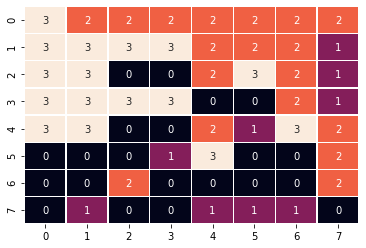

In [492]:
display_state_values(pis_PI[-1], env)
# LEFT = 0
# DOWN = 1
# RIGHT = 2
# UP = 3

In [493]:
get_score(env, pis_PI[-1], episodes=1000)

----------------------------------------------
You took an average of 72 steps to get the frisbee
And you fell in the hole 27.20 % of the times
----------------------------------------------


In [505]:
# is the policy from value and policy iteration the same?
np.array_equal(pis_PI[-1], policy_value_iteration)

False

### Q-Learning

In [530]:
action_size = env.action_space.n
state_size = env.observation_space.n

In [531]:
qtable = np.zeros((state_size, action_size))
qtable.shape

(64, 4)

In [532]:
total_episodes = 30000        # Total episodes
learning_rate = 0.9           # Learning rate
max_steps = 100                # Max steps per episode
gamma = 0.95                  # Discounting rate

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.1            # Minimum exploration probability 
decay_rate = 0.01            # Exponential decay rate for exploration prob

In [533]:
# the following function was inspired by and adapted from: https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Q%20learning/FrozenLake/Q%20Learning%20with%20FrozenLake.ipynb

# List of rewards
rewards = []
reward_achieved = 0

# 2 For life or until learning is stopped
for episode in range(total_episodes):
    # Reset the environment
    state = env.reset()
    old_state = 0
    step = 0
    done = False
    total_rewards = 0
    
    for step in range(max_steps):
        # 3. Choose an action a in the current world state (s)
        ## First we randomize a number
        exp_exp_tradeoff = random.uniform(0, 1)
        
        ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(qtable[state,:])
            # print("Exploiting knowledge!")

        # Else doing a random choice --> exploration
        else:
            action = env.action_space.sample()
            # print("Randomly exploring!")

        # print("Action: {}".format(action))

        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done, info = env.step(action)
        # print("Episode: {} Action: {} New State: {} R: {} Epsilon: {}".format(episode, action, new_state, reward, epsilon))

        # if done and reward == 0:
        #     reward = -0.5

        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        # qtable[new_state,:] : all the actions we can take from new state
        qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])
        
        total_rewards += reward
        
        # Our new state is state
        old_state = state
        state = new_state
        
        # If done (if we're dead) : finish episode
        if done == True:
            # print("Done") 
            if reward > 0:
                reward_achieved += 1
                # print(old_state, action)
                # print(qtable[old_state, action])
                # print(learning_rate * (reward + gamma * np.max(qtable[state, :]) - qtable[old_state, action]))
                # Reduce epsilon (because we need less and less exploration)
                # print(reward_achieved)
                # print(decay_rate)
                # print(np.exp(-decay_rate*reward_achieved))
                epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*reward_achieved)
                # print("Epsilon: {}".format(epsilon)) 
                print("Episode: {} Action: {} New State: {} R: {} Epsilon: {}".format(episode, action, new_state, reward, epsilon))
            break
        
    rewards.append(total_rewards)

print ("Number of rewards: " +  str(sum(rewards)))
print ("Score over time: " +  str(sum(rewards)/total_episodes))
print(qtable)

Episode: 800 Action: 2 New State: 63 R: 1.0 Epsilon: 0.9910448503742513
Episode: 898 Action: 1 New State: 63 R: 1.0 Epsilon: 0.9821788059760798
Episode: 1254 Action: 2 New State: 63 R: 1.0 Epsilon: 0.9734009801936573
Episode: 2001 Action: 1 New State: 63 R: 1.0 Epsilon: 0.9647104952370908
Episode: 2041 Action: 1 New State: 63 R: 1.0 Epsilon: 0.9561064820506426
Episode: 2263 Action: 1 New State: 63 R: 1.0 Epsilon: 0.9475880802258239
Episode: 2750 Action: 1 New State: 63 R: 1.0 Epsilon: 0.9391544379153535
Episode: 3015 Action: 1 New State: 63 R: 1.0 Epsilon: 0.9308047117479722
Episode: 3507 Action: 0 New State: 63 R: 1.0 Epsilon: 0.9225380667441053
Episode: 3527 Action: 1 New State: 63 R: 1.0 Epsilon: 0.9143536762323635
Episode: 3636 Action: 2 New State: 63 R: 1.0 Epsilon: 0.9062507217668754
Episode: 3897 Action: 0 New State: 63 R: 1.0 Epsilon: 0.8982283930454418
Episode: 3965 Action: 1 New State: 63 R: 1.0 Epsilon: 0.8902858878285052
Episode: 4189 Action: 2 New State: 63 R: 1.0 Epsilon:

In [534]:
qtable.shape

(64, 4)

In [535]:
# policy = [np.argmax(i) for i in qtable]
policy = np.argmax(qtable, axis=1)

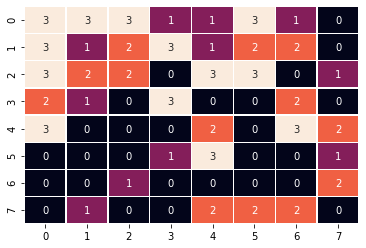

In [536]:
display_state_values(policy, env)
# LEFT = 0
# DOWN = 1
# RIGHT = 2
# UP = 3

In [540]:
# the following function was inspired by and adapted from: https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Q%20learning/FrozenLake/Q%20Learning%20with%20FrozenLake.ipynb

env.reset()

for episode in range(40):
    state = env.reset()
    step = 0
    done = False
    print("****************************************************")
    print("EPISODE ", episode)

    for step in range(max_steps):
        action = np.argmax(qtable[state,:])
        
        new_state, reward, done, info = env.step(action)
        
        if done:
            env.render()
            
            print("Number of steps", step)
            break
        state = new_state
env.close()

****************************************************
EPISODE  0
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Number of steps 96
****************************************************
EPISODE  1
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Number of steps 71
****************************************************
EPISODE  2
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Number of steps 45
****************************************************
EPISODE  3
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Number of steps 29
****************************************************
EPISODE  4
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Number of steps 30
****************************************************
EPISODE  5
****************************************************
EPISODE  6
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFF

In [538]:
get_score(env, policy,episodes=1000)

----------------------------------------------
You took an average of 82 steps to get the frisbee
And you fell in the hole 90.50 % of the times
----------------------------------------------


## Random MDP

In [181]:
n_states = 16
n_actions = 4
n_rewards = 1

# select which state actions gets a reward
n_state_actions = n_actions * n_states
selected_state_actions = np.arange(n_state_actions)
random.shuffle(selected_state_actions)
selected_state_actions=selected_state_actions[:n_rewards]


In [182]:
selected_state_actions

array([30])

In [183]:
env = {}
state_action = 0
for s in range(n_states):
    # print(s)
    env[s] = {}
    
    if s == n_states - 1:
        next_state = 0
    else:
        next_state = s + 1

    for a in range(n_actions):
        # print(a)
        if a == 0:
            # print("go to next state")
            if state_action in selected_state_actions:
                # print("add reward 1")
                env[s][a] = [(1, next_state, 1, False)]
            else:
                # print("add reward 0")
                env[s][a] = [(1, next_state, 0, False)]
        else:
            # print("go to random state but not next state")
            random_state_not_next = np.arange(n_states)
            np.delete(s+1, random_state_not_next)
            # print(random_state_not_next)
            random_state_not_next = random.choice(random_state_not_next)
            if state_action in selected_state_actions:
                # print("add reward 1")
                env[s][a] = [(1, random_state_not_next, 1, False)]
            else:
                # print("add reward 0")
                env[s][a] = [(1, random_state_not_next, 0, False)]
        state_action += 1

/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


In [184]:
env

{0: {0: [(1, 1, 0, False)],
  1: [(1, 13, 0, False)],
  2: [(1, 7, 0, False)],
  3: [(1, 0, 0, False)]},
 1: {0: [(1, 2, 0, False)],
  1: [(1, 6, 0, False)],
  2: [(1, 4, 0, False)],
  3: [(1, 4, 0, False)]},
 2: {0: [(1, 3, 0, False)],
  1: [(1, 11, 0, False)],
  2: [(1, 14, 0, False)],
  3: [(1, 9, 0, False)]},
 3: {0: [(1, 4, 0, False)],
  1: [(1, 9, 0, False)],
  2: [(1, 4, 0, False)],
  3: [(1, 3, 0, False)]},
 4: {0: [(1, 5, 0, False)],
  1: [(1, 1, 0, False)],
  2: [(1, 3, 0, False)],
  3: [(1, 3, 0, False)]},
 5: {0: [(1, 6, 0, False)],
  1: [(1, 0, 0, False)],
  2: [(1, 4, 0, False)],
  3: [(1, 5, 0, False)]},
 6: {0: [(1, 7, 0, False)],
  1: [(1, 3, 0, False)],
  2: [(1, 0, 0, False)],
  3: [(1, 1, 0, False)]},
 7: {0: [(1, 8, 0, False)],
  1: [(1, 15, 0, False)],
  2: [(1, 11, 1, False)],
  3: [(1, 5, 0, False)]},
 8: {0: [(1, 9, 0, False)],
  1: [(1, 4, 0, False)],
  2: [(1, 13, 0, False)],
  3: [(1, 1, 0, False)]},
 9: {0: [(1, 10, 0, False)],
  1: [(1, 7, 0, False)],
  2:

### Value Iteration

In [185]:
# the following function was inspired by and adapted from: https://github.com/realdiganta/solving_openai/blob/master/FrozenLake8x8/frozenLake8x8.py
def value_iteration(env, max_iterations=100000, lmbda=0.9, verbose=1):
    stateValue = [0 for i in range(n_states)]
    newStateValue = stateValue.copy()
    for i in range(max_iterations):
        
        if verbose>0: print("Iteration: {}".format(i))
        
        for state in range(n_states):
            action_values = []      
            
            for action in range(n_actions):
                state_value = 0
                
                for s in range(len(env[state][action])):
                    # print(s)
                    prob, next_state, reward, done = env[state][action][s]
                    
                    if verbose>1: 
                        print("Iteration: {} State: {} Action: {} Prob: {} Next State: {} Reward: {}".format(i, state, action, prob, next_state, reward))
                    state_action_value = prob * (reward + lmbda*stateValue[next_state])
                    state_value += state_action_value
                
                action_values.append(state_value)
                best_action = np.argmax(np.asarray(action_values))
                newStateValue[state] = action_values[best_action]
        
        # if i > 1000: 
        if verbose>0: print("Delta V: {}".format(np.max(np.abs(np.array(stateValue) - np.array(newStateValue)))))
        if np.max(np.abs(np.array(stateValue) - np.array(newStateValue))) < 0.0001:
            break
            
        stateValue = newStateValue.copy()
    return stateValue 

In [186]:
# the following function was inspired by and adapted from: https://github.com/realdiganta/solving_openai/blob/master/FrozenLake8x8/frozenLake8x8.py
def get_policy(env,stateValue, lmbda=0.9):
    policy = [0 for i in range(n_states)]
    for state in range(n_states):
        action_values = []
        for action in range(n_actions):
            action_value = 0
            # print(env.P[state][action])
            for i in range(len(env[state][action])):
                prob, next_state, r, _ = env[state][action][i]
                # print("I: {} R: {}".format(i, r))
                action_value += prob * (r + lmbda * stateValue[next_state])
            action_values.append(action_value)
        best_action = np.argmax(np.asarray(action_values))
        policy[state] = best_action
        # print("State: {} Action Values: {} Best Action: {}".format(state, action_values, best_action))
    return policy 

In [187]:
stateValues = value_iteration(env, max_iterations=100000, verbose=0)
policy_value_iteration = get_policy(env, stateValues)

### Policy Iteration

In [188]:
# the following function was inspired by and adapted from: https://github.com/hollygrimm/markov-decision-processes/blob/master/lab1/Lab%201%20-%20Problem%202.ipynb
def compute_vpi(pi, env, gamma):
    # use pi[state] to access the action that's prescribed by this policy
    a = np.identity(n_states) 
    b = np.zeros(n_states)
    # print(a)
    # print(b) 
    
    for state in range(n_states):
        for probability, nextstate, reward, done in env[state][pi[state]]:
            a[state][nextstate] = a[state][nextstate] - gamma * probability
            # print(probability * reward)
            b[state] += probability * reward
    
    # print(a)
    # print(b)
    V = np.linalg.solve(a, b)
    return V

In [189]:
pi = np.arange(n_states) % n_actions
Vpi = compute_vpi(pi, env, 0.9)

In [190]:
# the following function was inspired by and adapted from: https://github.com/hollygrimm/markov-decision-processes/blob/master/lab1/Lab%201%20-%20Problem%202.ipynb
def compute_qpi(vpi, env, gamma):
    Qpi = np.zeros([n_states, n_actions])
    for state in range(n_states):
        for action in range(n_actions):
            for probability, nextstate, reward, done in env[state][action]:
                Qpi[state][action] += probability * (reward + gamma * vpi[nextstate]) 
    return Qpi

In [191]:
Qpi = compute_qpi(Vpi, env, 0.9)

In [192]:
# the following function was inspired by and adapted from: https://github.com/hollygrimm/markov-decision-processes/blob/master/lab1/Lab%201%20-%20Problem%202.ipynb
def policy_iteration(env, gamma, nIt):
    Vs = []
    pis = []
    pi_prev = np.zeros(n_states, dtype='int')
    pis.append(pi_prev)
    print("Iteration | # chg actions | V[0]")
    print("----------+---------------+---------")
    for it in range(nIt):        
        
        # you need to compute qpi which is the state-action values for current pi
        vpi = compute_vpi(pis[-1], env, gamma=gamma)
        qpi = compute_qpi(vpi, env, gamma=gamma)
        pi = qpi.argmax(axis=1)
        print("%4i      | %6i        | %6.5f"%(it, (pi != pi_prev).sum(), vpi[0]))
        Vs.append(vpi)
        pis.append(pi)
        pi_prev = pi
    return Vs, pis

In [193]:
Vs_PI, pis_PI = policy_iteration(env, gamma=0.9, nIt=20)

Iteration | # chg actions | V[0]
----------+---------------+---------
   0      |      1        | 0.00000
   1      |     10        | 0.64131
   2      |      5        | 3.32103
   3      |      2        | 3.32103
   4      |      0        | 3.32103
   5      |      0        | 3.32103
   6      |      0        | 3.32103
   7      |      0        | 3.32103
   8      |      0        | 3.32103
   9      |      0        | 3.32103
  10      |      0        | 3.32103
  11      |      0        | 3.32103
  12      |      0        | 3.32103
  13      |      0        | 3.32103
  14      |      0        | 3.32103
  15      |      0        | 3.32103
  16      |      0        | 3.32103
  17      |      0        | 3.32103
  18      |      0        | 3.32103
  19      |      0        | 3.32103


### Q-learning

In [197]:
qtable = np.zeros((n_states, n_actions))
qtable.shape

(16, 4)

In [198]:
total_episodes = 30000        # Total episodes
learning_rate = 0.9           # Learning rate
max_steps = 100                # Max steps per episode
gamma = 0.95                  # Discounting rate

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.1            # Minimum exploration probability 
decay_rate = 0.01            # Exponential decay rate for exploration prob

In [199]:
# the following function was inspired by and adapted from: https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Q%20learning/FrozenLake/Q%20Learning%20with%20FrozenLake.ipynb

# List of rewards
rewards = []
reward_achieved = 0

# 2 For life or until learning is stopped
for episode in range(total_episodes):
    # Reset the environment
    state = 0
    old_state = 0
    step = 0
    done = False
    total_rewards = 0
    
    for step in range(max_steps):
        # 3. Choose an action a in the current world state (s)
        ## First we randomize a number
        exp_exp_tradeoff = random.uniform(0, 1)
        
        ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(qtable[state,:])
            print("Exploiting knowledge!")

        # Else doing a random choice --> exploration
        else:
            action = random.choice(np.arange(n_actions))
            print("Randomly exploring!")

        print("Action: {}".format(action))

        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done, info = env[state][action][0]
        print("Episode: {} Action: {} New State: {} R: {} Epsilon: {}".format(episode, action, new_state, reward, epsilon))

        # if done and reward == 0:
        #     reward = -0.5

        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        # qtable[new_state,:] : all the actions we can take from new state
        qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])
        
        total_rewards += reward
        
        # Our new state is state
        old_state = state
        state = new_state
        
        # If done (if we're dead) : finish episode
        if total_rewards == 10:
            # print("Done") 
            reward_achieved += 1
            # print(old_state, action)
            # print(qtable[old_state, action])
            # print(learning_rate * (reward + gamma * np.max(qtable[state, :]) - qtable[old_state, action]))
            # Reduce epsilon (because we need less and less exploration)
            # print(reward_achieved)
            # print(decay_rate)
            # print(np.exp(-decay_rate*reward_achieved))
            epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*reward_achieved)
            # print("Epsilon: {}".format(epsilon)) 
            # print("Episode: {} Action: {} New State: {} R: {} Epsilon: {}".format(episode, action, new_state, reward, epsilon))
            break
        
    rewards.append(total_rewards)

print ("Number of rewards: " +  str(sum(rewards)))
print ("Score over time: " +  str(sum(rewards)/total_episodes))
print(qtable)

.36837755148689866
Exploiting knowledge!
Action: 1
Episode: 2212 Action: 1 New State: 1 R: 6 Epsilon: 0.36837755148689866
Randomly exploring!
Action: 3
Episode: 2212 Action: 3 New State: 1 R: 4 Epsilon: 0.36837755148689866
Exploiting knowledge!
Action: 1
Episode: 2212 Action: 1 New State: 1 R: 6 Epsilon: 0.36837755148689866
Exploiting knowledge!
Action: 1
Episode: 2212 Action: 1 New State: 1 R: 6 Epsilon: 0.36837755148689866
Randomly exploring!
Action: 1
Episode: 2212 Action: 1 New State: 1 R: 6 Epsilon: 0.36837755148689866
Exploiting knowledge!
Action: 1
Episode: 2212 Action: 1 New State: 1 R: 6 Epsilon: 0.36837755148689866
Exploiting knowledge!
Action: 1
Episode: 2212 Action: 1 New State: 1 R: 6 Epsilon: 0.36837755148689866
Randomly exploring!
Action: 2
Episode: 2212 Action: 2 New State: 1 R: 4 Epsilon: 0.36837755148689866
Exploiting knowledge!
Action: 1
Episode: 2212 Action: 1 New State: 1 R: 6 Epsilon: 0.36837755148689866
Randomly exploring!
Action: 0
Episode: 2212 Action: 0 New St

KeyboardInterrupt: 